In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)

tf.random.set_seed(2)

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]


In [2]:
df = pd.read_csv("processminer-rare-event-mts - data.csv") 
df.head(n=5)  # visualize the data.

time  y        x1        x2        x3         x4        x5  \
0  5/1/99 0:00  0  0.376665 -4.596435 -4.095756  13.497687 -0.118830   
1  5/1/99 0:02  0  0.475720 -4.542502 -4.018359  16.230659 -0.128733   
2  5/1/99 0:04  0  0.363848 -4.681394 -4.353147  14.127997 -0.138636   
3  5/1/99 0:06  0  0.301590 -4.758934 -4.023612  13.161566 -0.148142   
4  5/1/99 0:08  0  0.265578 -4.749928 -4.333150  15.267340 -0.155314   

          x6        x7        x8  ...        x52       x53       x54  \
0 -20.669883  0.000732 -0.061114  ...  10.091721  0.053279 -4.936434   
1 -18.758079  0.000732 -0.061114  ...  10.095871  0.062801 -4.937179   
2 -17.836632  0.010803 -0.061114  ...  10.100265  0.072322 -4.937924   
3 -18.517601  0.002075 -0.061114  ...  10.104660  0.081600 -4.938669   
4 -17.505913  0.000732 -0.061114  ...  10.109054  0.091121 -4.939414   

         x55        x56       x57       x58       x59       x60  x61  
0 -24.590146  18.515436  3.473400  0.033444  0.953219  0.006076    0  
1 -32.413266  22.760065  2.682933  0.033536  1.090502  0.006083    0  
2 -34.183774  27.004663  3.537487  0.033629  1.840540  0.006090    0  
3 -35.954281  21.672449  3.986095  0.033721  2.554880  0.006097    0  
4 -37.724789  21.907251  3.601573  0.033777  1.410494  0.006105    0  

[5 rows x 63 columns]

In [3]:
df.count()

time    18398
y       18398
x1      18398
x2      18398
x3      18398
        ...  
x57     18398
x58     18398
x59     18398
x60     18398
x61     18398
Length: 63, dtype: int64

### Shift the data

This is a timeseries data in which we have to predict the event (y = 1) ahead in time. In this data, consecutive rows are 2 minutes apart. We will shift the labels in column `y` by 2 rows to do a 4 minute ahead prediction.

In [4]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [5]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


time  y        x1         x2         x3
256   5/1/99 8:32  0  1.016235  -4.058394  -1.097158
257   5/1/99 8:34  0  1.005602  -3.876199  -1.074373
258   5/1/99 8:36  0  0.933933  -3.868467  -1.249954
259   5/1/99 8:38  1  0.892311 -13.332664 -10.006578
260  5/1/99 10:50  0  0.020062  -3.987897  -1.248529

After shifting


y          time        x1        x2        x3
255  0.0   5/1/99 8:30  0.997107 -3.865720 -1.133779
256  0.0   5/1/99 8:32  1.016235 -4.058394 -1.097158
257  1.0   5/1/99 8:34  1.005602 -3.876199 -1.074373
258  1.0   5/1/99 8:36  0.933933 -3.868467 -1.249954
260  0.0  5/1/99 10:50  0.020062 -3.987897 -1.248529

In [6]:
df.count()

y       18274
time    18274
x1      18274
x2      18274
x3      18274
        ...  
x57     18274
x58     18274
x59     18274
x60     18274
x61     18274
Length: 63, dtype: int64

In [7]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18274 entries, 0 to 18397
Data columns (total 60 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       18274 non-null  float64
 1   x1      18274 non-null  float64
 2   x2      18274 non-null  float64
 3   x3      18274 non-null  float64
 4   x4      18274 non-null  float64
 5   x5      18274 non-null  float64
 6   x6      18274 non-null  float64
 7   x7      18274 non-null  float64
 8   x8      18274 non-null  float64
 9   x9      18274 non-null  float64
 10  x10     18274 non-null  float64
 11  x11     18274 non-null  float64
 12  x12     18274 non-null  float64
 13  x13     18274 non-null  float64
 14  x14     18274 non-null  float64
 15  x15     18274 non-null  float64
 16  x16     18274 non-null  float64
 17  x17     18274 non-null  float64
 18  x18     18274 non-null  float64
 19  x19     18274 non-null  float64
 20  x20     18274 non-null  float64
 21  x21     18274 non-null  float64
 22

### Divide the data into train, valid, and test

In [9]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [10]:
df_train.shape[0]

11695

In [11]:
df_test.shape[0]

3655

In [12]:
df_valid.shape[0]

2924

In the autoencoder, we will be encoding only the negatively labeled data. That is, we will take the part of data for which `y=0` and build an autoencoder. For that, we will divide the datasets as following.

In [13]:
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

### Standardize the data
It is usually better to use a standardized data (transformed to Gaussian, mean 0 and sd 1) for autoencoders.

In [14]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

## Autoencoder training

First we will initialize the Autoencoder architecture. We are building a simple autoencoder. More complex architectures and other configurations should be explored.

In [15]:
nb_epoch = 200
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 59)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                1920      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 59)                1947      
Total params: 5,211
Trainable params: 5,211
Non-trainable params: 0
___________________________________________________________

2022-10-07 12:00:23.809206: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 12:00:23.811581: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [16]:
decoder

<tf.Tensor 'dense_4/Identity:0' shape=(None, 59) dtype=float32>

In [17]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=3)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 11541 samples, validate on 2883 samples
Epoch 1/200
 4224/11541 [=========>....................] - ETA: 1s - loss: 0.9959 - accuracy: 0.0220

2022-10-07 12:00:38.682393: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


11264/11541 [============================>.] - ETA: 0s - loss: 0.8881 - accuracy: 0.0476
Epoch 00001: val_loss improved from inf to 0.69021, saving model to autoencoder_classifier.h5
11541/11541 [==============================] - 1s 117us/sample - loss: 0.8830 - accuracy: 0.0472 - val_loss: 0.6902 - val_accuracy: 0.0496
Epoch 2/200
11136/11541 [===========================>..] - ETA: 0s - loss: 0.5604 - accuracy: 0.0998
Epoch 00002: val_loss improved from 0.69021 to 0.47524, saving model to autoencoder_classifier.h5
11541/11541 [==============================] - 0s 42us/sample - loss: 0.5578 - accuracy: 0.1016 - val_loss: 0.4752 - val_accuracy: 0.1398
Epoch 3/200
10880/11541 [===========================>..] - ETA: 0s - loss: 0.4254 - accuracy: 0.1762
Epoch 00003: val_loss improved from 0.47524 to 0.38738, saving model to autoencoder_classifier.h5
11541/11541 [==============================] - 0s 41us/sample - loss: 0.4218 - accuracy: 0.1761 - val_loss: 0.3874 - val_accuracy: 0.2092
Epoc

Epoch 26/200
11136/11541 [===========================>..] - ETA: 0s - loss: 0.1640 - accuracy: 0.5091
Epoch 00026: val_loss improved from 0.16985 to 0.16677, saving model to autoencoder_classifier.h5
11541/11541 [==============================] - 0s 42us/sample - loss: 0.1638 - accuracy: 0.5093 - val_loss: 0.1668 - val_accuracy: 0.5082
Epoch 27/200
10112/11541 [=========================>....] - ETA: 0s - loss: 0.1597 - accuracy: 0.5171
Epoch 00027: val_loss improved from 0.16677 to 0.16596, saving model to autoencoder_classifier.h5
11541/11541 [==============================] - 1s 44us/sample - loss: 0.1616 - accuracy: 0.5146 - val_loss: 0.1660 - val_accuracy: 0.5140
Epoch 28/200
10880/11541 [===========================>..] - ETA: 0s - loss: 0.1599 - accuracy: 0.5165
Epoch 00028: val_loss improved from 0.16596 to 0.16250, saving model to autoencoder_classifier.h5
11541/11541 [==============================] - 0s 41us/sample - loss: 0.1595 - accuracy: 0.5160 - val_loss: 0.1625 - val_acc

Epoch 51/200
10752/11541 [==========================>...] - ETA: 0s - loss: 0.1280 - accuracy: 0.5657
Epoch 00051: val_loss improved from 0.13335 to 0.13214, saving model to autoencoder_classifier.h5
11541/11541 [==============================] - 0s 42us/sample - loss: 0.1285 - accuracy: 0.5649 - val_loss: 0.1321 - val_accuracy: 0.5588
Epoch 52/200
11136/11541 [===========================>..] - ETA: 0s - loss: 0.1274 - accuracy: 0.5648
Epoch 00052: val_loss improved from 0.13214 to 0.13161, saving model to autoencoder_classifier.h5
11541/11541 [==============================] - 0s 42us/sample - loss: 0.1277 - accuracy: 0.5662 - val_loss: 0.1316 - val_accuracy: 0.5557
Epoch 53/200
10240/11541 [=========================>....] - ETA: 0s - loss: 0.1269 - accuracy: 0.5663
Epoch 00053: val_loss improved from 0.13161 to 0.13130, saving model to autoencoder_classifier.h5
11541/11541 [==============================] - 1s 54us/sample - loss: 0.1272 - accuracy: 0.5670 - val_loss: 0.1313 - val_acc

Epoch 76/200
10368/11541 [=========================>....] - ETA: 0s - loss: 0.1150 - accuracy: 0.5689
Epoch 00076: val_loss did not improve from 0.12014
11541/11541 [==============================] - 0s 43us/sample - loss: 0.1155 - accuracy: 0.5682 - val_loss: 0.1214 - val_accuracy: 0.5602
Epoch 77/200
10496/11541 [==========================>...] - ETA: 0s - loss: 0.1169 - accuracy: 0.5637
Epoch 00077: val_loss improved from 0.12014 to 0.11895, saving model to autoencoder_classifier.h5
11541/11541 [==============================] - 0s 42us/sample - loss: 0.1164 - accuracy: 0.5660 - val_loss: 0.1190 - val_accuracy: 0.5616
Epoch 78/200
11008/11541 [===========================>..] - ETA: 0s - loss: 0.1149 - accuracy: 0.5710
Epoch 00078: val_loss improved from 0.11895 to 0.11862, saving model to autoencoder_classifier.h5
11541/11541 [==============================] - 0s 42us/sample - loss: 0.1147 - accuracy: 0.5710 - val_loss: 0.1186 - val_accuracy: 0.5702
Epoch 79/200
10368/11541 [=======

Epoch 127/200
10880/11541 [===========================>..] - ETA: 0s - loss: 0.0983 - accuracy: 0.5993
Epoch 00127: val_loss improved from 0.10082 to 0.10029, saving model to autoencoder_classifier.h5
11541/11541 [==============================] - 0s 42us/sample - loss: 0.0983 - accuracy: 0.5997 - val_loss: 0.1003 - val_accuracy: 0.5834
Epoch 128/200
10752/11541 [==========================>...] - ETA: 0s - loss: 0.0980 - accuracy: 0.5992
Epoch 00128: val_loss improved from 0.10029 to 0.10013, saving model to autoencoder_classifier.h5
11541/11541 [==============================] - 0s 42us/sample - loss: 0.0979 - accuracy: 0.5986 - val_loss: 0.1001 - val_accuracy: 0.5872
Epoch 129/200
10368/11541 [=========================>....] - ETA: 0s - loss: 0.0980 - accuracy: 0.6007
Epoch 00129: val_loss did not improve from 0.10013
11541/11541 [==============================] - 0s 41us/sample - loss: 0.0978 - accuracy: 0.6009 - val_loss: 0.1007 - val_accuracy: 0.5831
Epoch 130/200
10624/11541 [===

Epoch 153/200
11264/11541 [============================>.] - ETA: 0s - loss: 0.0941 - accuracy: 0.6066
Epoch 00153: val_loss did not improve from 0.09589
11541/11541 [==============================] - 0s 39us/sample - loss: 0.0940 - accuracy: 0.6072 - val_loss: 0.0965 - val_accuracy: 0.6042
Epoch 154/200
11008/11541 [===========================>..] - ETA: 0s - loss: 0.0934 - accuracy: 0.6082
Epoch 00154: val_loss did not improve from 0.09589
11541/11541 [==============================] - 0s 40us/sample - loss: 0.0938 - accuracy: 0.6074 - val_loss: 0.0965 - val_accuracy: 0.5928
Epoch 155/200
10880/11541 [===========================>..] - ETA: 0s - loss: 0.0938 - accuracy: 0.6081
Epoch 00155: val_loss did not improve from 0.09589
11541/11541 [==============================] - 0s 40us/sample - loss: 0.0938 - accuracy: 0.6073 - val_loss: 0.0963 - val_accuracy: 0.6139
Epoch 156/200
11008/11541 [===========================>..] - ETA: 0s - loss: 0.0941 - accuracy: 0.6102
Epoch 00156: val_loss

Epoch 180/200
11136/11541 [===========================>..] - ETA: 0s - loss: 0.0909 - accuracy: 0.6122
Epoch 00180: val_loss did not improve from 0.09326
11541/11541 [==============================] - 1s 52us/sample - loss: 0.0910 - accuracy: 0.6126 - val_loss: 0.0938 - val_accuracy: 0.6080
Epoch 181/200
10624/11541 [==========================>...] - ETA: 0s - loss: 0.0913 - accuracy: 0.6162
Epoch 00181: val_loss improved from 0.09326 to 0.09290, saving model to autoencoder_classifier.h5
11541/11541 [==============================] - 1s 62us/sample - loss: 0.0911 - accuracy: 0.6164 - val_loss: 0.0929 - val_accuracy: 0.6063
Epoch 182/200
11008/11541 [===========================>..] - ETA: 0s - loss: 0.0907 - accuracy: 0.6143
Epoch 00182: val_loss did not improve from 0.09290
11541/11541 [==============================] - 1s 53us/sample - loss: 0.0908 - accuracy: 0.6146 - val_loss: 0.0936 - val_accuracy: 0.5973
Epoch 183/200
11520/11541 [============================>.] - ETA: 0s - loss: 

In [18]:
autoencoder = load_model('autoencoder_classifier.h5',compile=False)

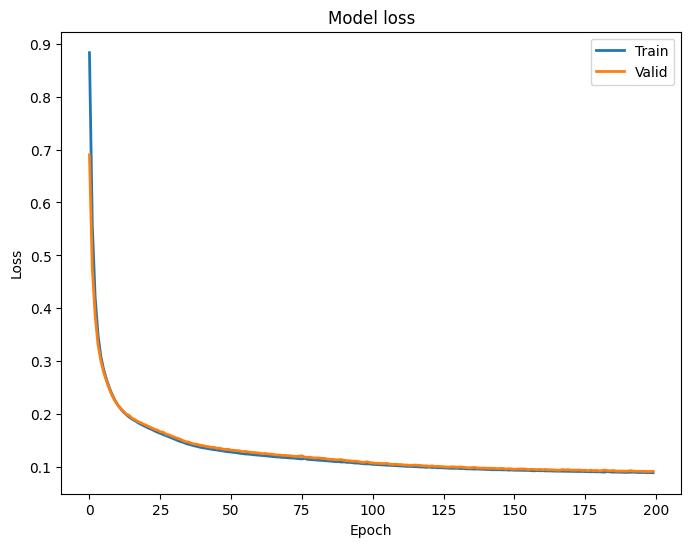

In [19]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

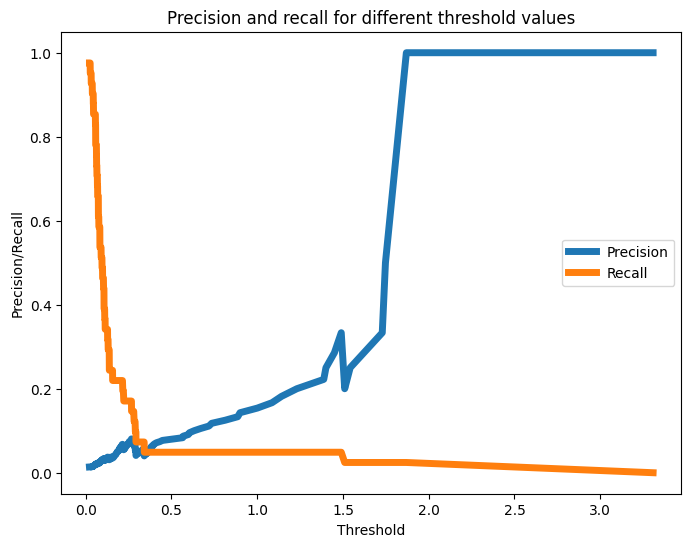

In [20]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [21]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()

In [22]:
error_df_test

index  Reconstruction_error  True_class
0      9735              0.047330         0.0
1      1997              0.074778         0.0
2      4121              0.046022         0.0
3      1888              0.025748         0.0
4      4040              0.081177         0.0
...     ...                   ...         ...
3650   1667              0.169302         0.0
3651   9704              0.064735         0.0
3652   5760              0.057156         0.0
3653  14795              0.043038         0.0
3654  16377              0.060169         0.0

[3655 rows x 3 columns]

In [23]:
error_df_test['True_class'].value_counts()

0.0    3603
1.0      52
Name: True_class, dtype: int64

In [24]:
error_df_test_1 = error_df_test.loc[error_df_test.True_class==1.0, :]
error_df_test_1

index  Reconstruction_error  True_class
30     6218              0.120971         1.0
43    16921              0.039631         1.0
110   11827              0.117989         1.0
155   15525              0.077132         1.0
402    1343              0.038663         1.0
443   16258              0.025467         1.0
469   15737              0.096923         1.0
514   15704              0.077434         1.0
610    8220              0.030983         1.0
712    2373              0.155097         1.0
943    4795              0.092838         1.0
959    7242              0.070292         1.0
986    3520              0.099019         1.0
989    2310              1.702193         1.0
1109   2712              0.026222         1.0
1233   4175              0.100362         1.0
1316   8021              0.137419         1.0
1401  10815              0.123287         1.0
1406  11573              0.108357         1.0
1499  14514              0.095427         1.0
1507   1749              0.040760         1.0
1670   2962              0.058727         1.0
1890  15667              0.126333         1.0
2097   2315              0.169875         1.0
2121   8082              0.060595         1.0
2142   8235              0.026394         1.0
2163  10240              0.282030         1.0
2319   7172              0.067180         1.0
2367  15668              0.147559         1.0
2411    775              0.186881         1.0
2505   8070              0.069146         1.0
2509   3597              0.057619         1.0
2531   7241              0.078337         1.0
2606   1299              0.029488         1.0
2689   4176              0.093397         1.0
2721   7937              0.052993         1.0
2818  10835              0.214808         1.0
2826  13612              0.105976         1.0
2827  15769              0.179187         1.0
2849    257              0.103861         1.0
2961  17864              0.062778         1.0
2962    833              0.048816         1.0
2985  14136              0.074764         1.0
3073  16257              0.022945         1.0
3221  15924              0.157108         1.0
3235   1342              0.034859         1.0
3236   8081              0.061209         1.0
3306  15565              0.074704         1.0
3570   2316              0.188640         1.0
3583  17203              0.066049         1.0
3618   2590              0.071522         1.0
3643   8474              0.029444         1.0

In [25]:
error_df_test_2 = error_df_test.loc[error_df_test.True_class==0.0, :]
error_df_test_2

index  Reconstruction_error  True_class
0      9735              0.047330         0.0
1      1997              0.074778         0.0
2      4121              0.046022         0.0
3      1888              0.025748         0.0
4      4040              0.081177         0.0
...     ...                   ...         ...
3650   1667              0.169302         0.0
3651   9704              0.064735         0.0
3652   5760              0.057156         0.0
3653  14795              0.043038         0.0
3654  16377              0.060169         0.0

[3603 rows x 3 columns]

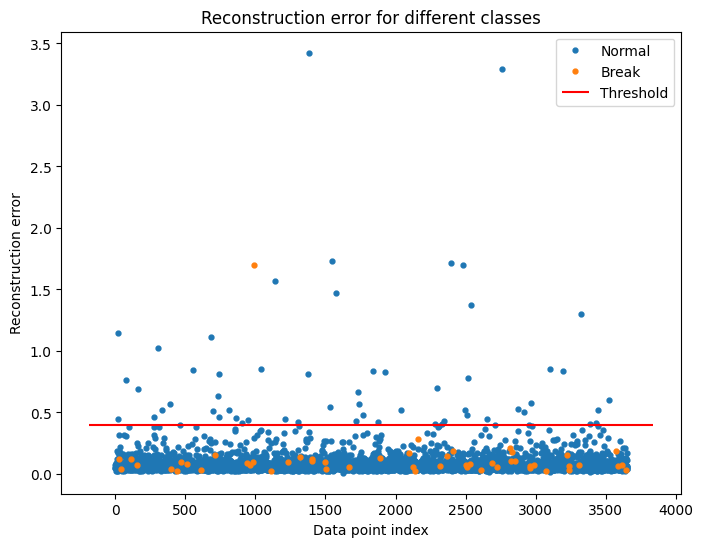

In [26]:
threshold_fixed = 0.4
groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [27]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]


In [28]:
predictions = pd.DataFrame({'true': error_df.True_class,
                           'predicted': pred_y})

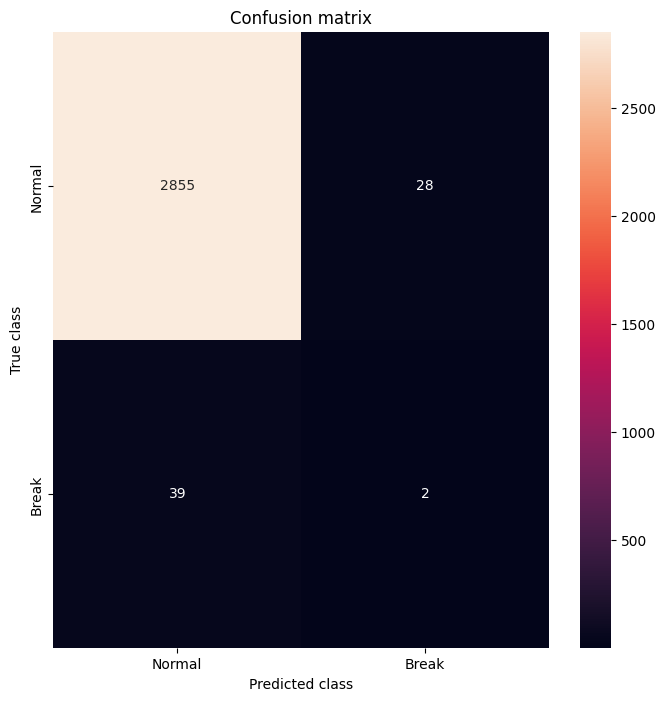

In [29]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [30]:
target_names = ['Normal', 'Break']

print(classification_report(error_df.True_class, pred_y, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      2883
       Break       0.07      0.05      0.06        41

    accuracy                           0.98      2924
   macro avg       0.53      0.52      0.52      2924
weighted avg       0.97      0.98      0.98      2924



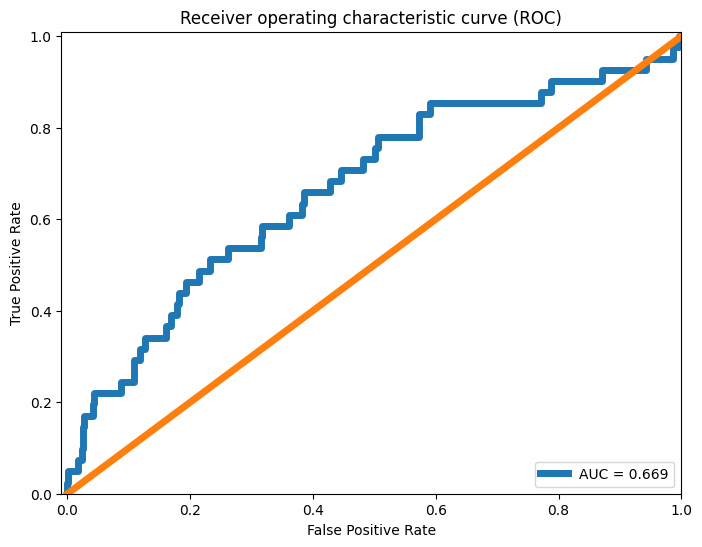

In [31]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Using sampling techniques

In [2]:
df = pd.read_csv("processminer-rare-event-mts - data.csv") 
df.head(n=5)  # visualize the data.

time  y        x1        x2        x3         x4        x5  \
0  5/1/99 0:00  0  0.376665 -4.596435 -4.095756  13.497687 -0.118830   
1  5/1/99 0:02  0  0.475720 -4.542502 -4.018359  16.230659 -0.128733   
2  5/1/99 0:04  0  0.363848 -4.681394 -4.353147  14.127997 -0.138636   
3  5/1/99 0:06  0  0.301590 -4.758934 -4.023612  13.161566 -0.148142   
4  5/1/99 0:08  0  0.265578 -4.749928 -4.333150  15.267340 -0.155314   

          x6        x7        x8  ...        x52       x53       x54  \
0 -20.669883  0.000732 -0.061114  ...  10.091721  0.053279 -4.936434   
1 -18.758079  0.000732 -0.061114  ...  10.095871  0.062801 -4.937179   
2 -17.836632  0.010803 -0.061114  ...  10.100265  0.072322 -4.937924   
3 -18.517601  0.002075 -0.061114  ...  10.104660  0.081600 -4.938669   
4 -17.505913  0.000732 -0.061114  ...  10.109054  0.091121 -4.939414   

         x55        x56       x57       x58       x59       x60  x61  
0 -24.590146  18.515436  3.473400  0.033444  0.953219  0.006076    0  
1 -32.413266  22.760065  2.682933  0.033536  1.090502  0.006083    0  
2 -34.183774  27.004663  3.537487  0.033629  1.840540  0.006090    0  
3 -35.954281  21.672449  3.986095  0.033721  2.554880  0.006097    0  
4 -37.724789  21.907251  3.601573  0.033777  1.410494  0.006105    0  

[5 rows x 63 columns]

In [63]:
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

In [64]:
print(df_train_0.y.value_counts())
print(df_train_1.y.value_counts())

0.0    11541
Name: y, dtype: int64
1.0    154
Name: y, dtype: int64


In [65]:
from sklearn.utils import resample

# upsample minority class
df_minority_upsampled = resample(df_train_1,
                                   replace=True,  # sample without replacement
                                   n_samples=df_train_0.shape[0],  # to match majority class
                                   random_state=123)  # reproducible results


In [66]:
df_minority_upsampled.shape[0]

11541

In [67]:
df_upsampled = pd.concat([df_train_0, df_minority_upsampled])
df_upsampled.y.value_counts()

0.0    11541
1.0    11541
Name: y, dtype: int64

In [68]:
y = df_upsampled.y
df_train_X = df_upsampled.drop('y', axis=1)

In [69]:
scaler = StandardScaler().fit(df_train_X)
df_train_X_rescaled = scaler.transform(df_train_X)

df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

In [70]:
nb_epoch = 200
batch_size = 64
input_dim = df_train_X_rescaled.shape[1] 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 59)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1920      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_9 (Dense)              (None, 59)                1947      
Total params: 5,211
Trainable params: 5,211
Non-trainable params: 0
_________________________________________________________

In [72]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier_sampled.h5",
                               save_best_only=True,
                               verbose=3)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_X_rescaled, df_train_X_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 23082 samples, validate on 2883 samples
Epoch 1/200
 2176/23082 [=>............................] - ETA: 6s - loss: 0.0933 - accuracy: 0.6641

2022-10-06 20:56:17.789556: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


22720/23082 [============================>.] - ETA: 0s - loss: 0.0888 - accuracy: 0.6576
Epoch 00001: val_loss improved from inf to 0.11551, saving model to autoencoder_classifier_sampled.h5
23082/23082 [==============================] - 2s 106us/sample - loss: 0.0886 - accuracy: 0.6584 - val_loss: 0.1155 - val_accuracy: 0.5768
Epoch 2/200
22656/23082 [============================>.] - ETA: 0s - loss: 0.0887 - accuracy: 0.6577
Epoch 00002: val_loss did not improve from 0.11551
23082/23082 [==============================] - 2s 87us/sample - loss: 0.0885 - accuracy: 0.6580 - val_loss: 0.1157 - val_accuracy: 0.5803
Epoch 3/200
22784/23082 [============================>.] - ETA: 0s - loss: 0.0886 - accuracy: 0.6583
Epoch 00003: val_loss did not improve from 0.11551
23082/23082 [==============================] - 2s 76us/sample - loss: 0.0885 - accuracy: 0.6581 - val_loss: 0.1168 - val_accuracy: 0.5800
Epoch 4/200
23040/23082 [============================>.] - ETA: 0s - loss: 0.0887 - accura

Epoch 56/200
22784/23082 [============================>.] - ETA: 0s - loss: 0.0865 - accuracy: 0.6569
Epoch 00056: val_loss did not improve from 0.11294
23082/23082 [==============================] - 2s 90us/sample - loss: 0.0867 - accuracy: 0.6573 - val_loss: 0.1140 - val_accuracy: 0.5751
Epoch 57/200
22784/23082 [============================>.] - ETA: 0s - loss: 0.0865 - accuracy: 0.6573
Epoch 00057: val_loss did not improve from 0.11294
23082/23082 [==============================] - 2s 82us/sample - loss: 0.0865 - accuracy: 0.6574 - val_loss: 0.1145 - val_accuracy: 0.5858
Epoch 58/200
22400/23082 [============================>.] - ETA: 0s - loss: 0.0873 - accuracy: 0.6562
Epoch 00058: val_loss did not improve from 0.11294
23082/23082 [==============================] - 2s 72us/sample - loss: 0.0870 - accuracy: 0.6562 - val_loss: 0.1141 - val_accuracy: 0.5820
Epoch 59/200
22528/23082 [============================>.] - ETA: 0s - loss: 0.0865 - accuracy: 0.6591
Epoch 00059: val_loss imp

Epoch 84/200
22912/23082 [============================>.] - ETA: 0s - loss: 0.0862 - accuracy: 0.6518
Epoch 00084: val_loss did not improve from 0.11265
23082/23082 [==============================] - 2s 76us/sample - loss: 0.0861 - accuracy: 0.6521 - val_loss: 0.1127 - val_accuracy: 0.5883
Epoch 85/200
22464/23082 [============================>.] - ETA: 0s - loss: 0.0858 - accuracy: 0.6544
Epoch 00085: val_loss improved from 0.11265 to 0.11252, saving model to autoencoder_classifier_sampled.h5
23082/23082 [==============================] - 2s 77us/sample - loss: 0.0858 - accuracy: 0.6545 - val_loss: 0.1125 - val_accuracy: 0.5678
Epoch 86/200
22336/23082 [============================>.] - ETA: 0s - loss: 0.0855 - accuracy: 0.6540
Epoch 00086: val_loss did not improve from 0.11252
23082/23082 [==============================] - 2s 73us/sample - loss: 0.0858 - accuracy: 0.6533 - val_loss: 0.1129 - val_accuracy: 0.5744
Epoch 87/200
22528/23082 [============================>.] - ETA: 0s - lo

Epoch 112/200
22848/23082 [============================>.] - ETA: 0s - loss: 0.0854 - accuracy: 0.6531
Epoch 00112: val_loss did not improve from 0.11113
23082/23082 [==============================] - 2s 83us/sample - loss: 0.0854 - accuracy: 0.6531 - val_loss: 0.1130 - val_accuracy: 0.5845
Epoch 113/200
22400/23082 [============================>.] - ETA: 0s - loss: 0.0856 - accuracy: 0.6538
Epoch 00113: val_loss did not improve from 0.11113
23082/23082 [==============================] - 2s 73us/sample - loss: 0.0854 - accuracy: 0.6537 - val_loss: 0.1169 - val_accuracy: 0.5803
Epoch 114/200
22848/23082 [============================>.] - ETA: 0s - loss: 0.0854 - accuracy: 0.6545
Epoch 00114: val_loss did not improve from 0.11113
23082/23082 [==============================] - 2s 74us/sample - loss: 0.0853 - accuracy: 0.6548 - val_loss: 0.1116 - val_accuracy: 0.5872
Epoch 115/200
22720/23082 [============================>.] - ETA: 0s - loss: 0.0852 - accuracy: 0.6541
Epoch 00115: val_loss

Epoch 140/200
22336/23082 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.6521
Epoch 00140: val_loss did not improve from 0.11050
23082/23082 [==============================] - 2s 72us/sample - loss: 0.0847 - accuracy: 0.6538 - val_loss: 0.1116 - val_accuracy: 0.5754
Epoch 141/200
23040/23082 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.6528
Epoch 00141: val_loss did not improve from 0.11050
23082/23082 [==============================] - 2s 73us/sample - loss: 0.0847 - accuracy: 0.6528 - val_loss: 0.1113 - val_accuracy: 0.5772
Epoch 142/200
22656/23082 [============================>.] - ETA: 0s - loss: 0.0844 - accuracy: 0.6516
Epoch 00142: val_loss did not improve from 0.11050
23082/23082 [==============================] - 2s 72us/sample - loss: 0.0844 - accuracy: 0.6523 - val_loss: 0.1112 - val_accuracy: 0.5709
Epoch 143/200
22784/23082 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.6518
Epoch 00143: val_loss

22848/23082 [============================>.] - ETA: 0s - loss: 0.0834 - accuracy: 0.6555
Epoch 00194: val_loss did not improve from 0.10950
23082/23082 [==============================] - 2s 83us/sample - loss: 0.0835 - accuracy: 0.6561 - val_loss: 0.1098 - val_accuracy: 0.5914
Epoch 195/200
22656/23082 [============================>.] - ETA: 0s - loss: 0.0840 - accuracy: 0.6560
Epoch 00195: val_loss improved from 0.10950 to 0.10911, saving model to autoencoder_classifier_sampled.h5
23082/23082 [==============================] - 2s 85us/sample - loss: 0.0838 - accuracy: 0.6562 - val_loss: 0.1091 - val_accuracy: 0.5806
Epoch 196/200
22720/23082 [============================>.] - ETA: 0s - loss: 0.0838 - accuracy: 0.6559
Epoch 00196: val_loss did not improve from 0.10911
23082/23082 [==============================] - 2s 88us/sample - loss: 0.0841 - accuracy: 0.6558 - val_loss: 0.1104 - val_accuracy: 0.5789
Epoch 197/200
22528/23082 [============================>.] - ETA: 0s - loss: 0.0839

In [73]:
autoencoder = load_model('autoencoder_classifier_sampled.h5',compile=False)

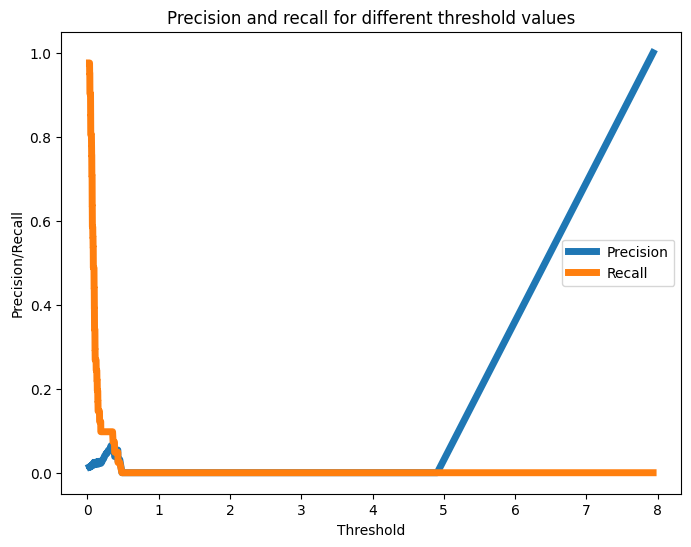

In [74]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [75]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()

In [76]:
error_df_test['True_class'].value_counts()

0.0    3603
1.0      52
Name: True_class, dtype: int64

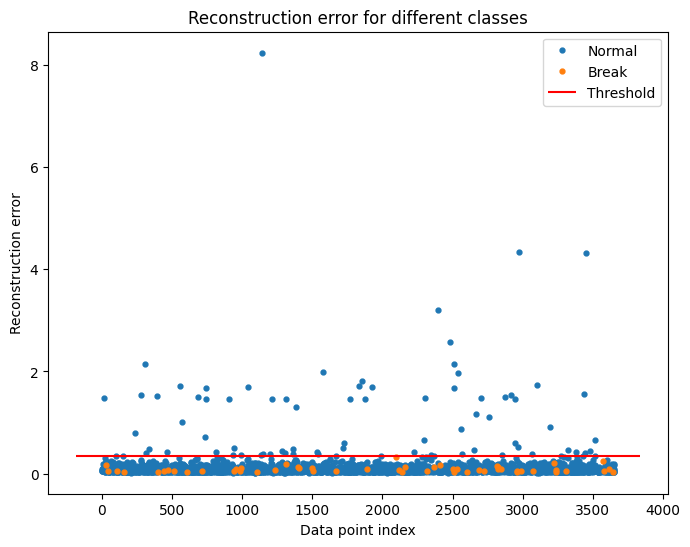

In [92]:
threshold_fixed = 0.35
groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [93]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]


In [94]:
predictions = pd.DataFrame({'true': error_df.True_class,
                           'predicted': pred_y})

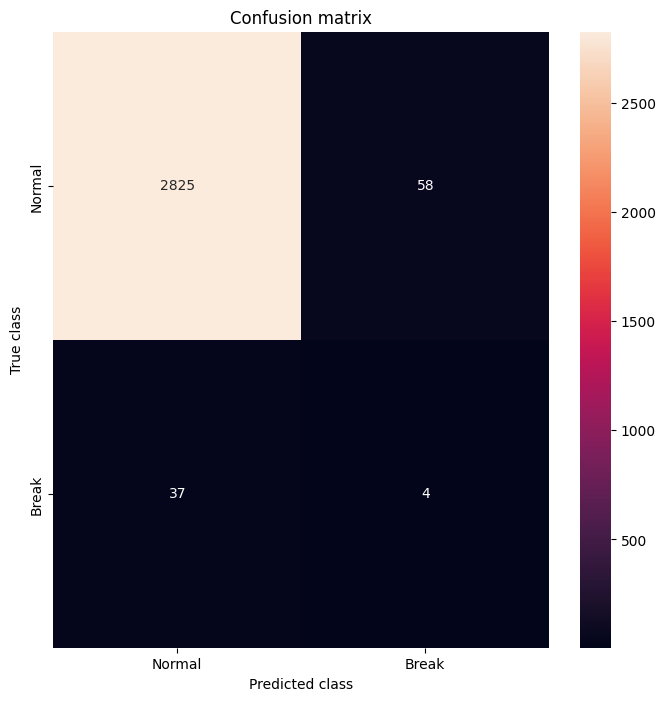

In [95]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [96]:
target_names = ['Normal', 'Break']

print(classification_report(error_df.True_class, pred_y, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98      2883
       Break       0.06      0.10      0.08        41

    accuracy                           0.97      2924
   macro avg       0.53      0.54      0.53      2924
weighted avg       0.97      0.97      0.97      2924

